In [1]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import yfinance as yf

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
def get_model(path):
  return load_model(path)

In [4]:
Window=30
def get_data(predday,series):
  # fixed input size to model, last 30 day
    Predday = predday

    # To split the data into 90:10
    Trainsplit = 0.9

    cut = int(series.shape[0]*Trainsplit)

    # train
    closetrain = series[:cut]
    # test
    closetest = series[cut:-(Window+Predday)]
    # forecast for future 7 days
    closeforecast = series[-(Window+Predday):]

    return closetrain,closetest,closeforecast

In [5]:
def windowed_dataset(series, window_size,predday, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-predday], tf.squeeze(w[-predday:])))
    return ds.batch(batch_size).prefetch(3)

In [6]:
def future_predicted(testbatches,window_size,predday):
  x,y = next(iter(testbatches))
  output = model.predict(x)

  time=list(range(1,window_size+1))
  time2=list(range(window_size+1,window_size+predday+1))
  plt.plot(time,x[0])
  plt.plot(time2,output[0])
  plt.legend(['Actual Values','Predicted Values'])
  plt.title('Prediction for {} Days'.format(predday))

In [7]:
def visualplotloss(dataset,model,z,predday):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(z-1,(z-1)+predday))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

In [8]:
# using JD as its not as stable
df=yf.download('AAPL', start='2015-07-01', end='2023-07-01')
df.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-01,31.725000,31.735001,31.497499,31.650000,28.599470,120955200
2015-07-02,31.607500,31.672501,31.442499,31.610001,28.563326,108844000
2015-07-06,31.235001,31.557501,31.212500,31.500000,28.463924,112241600
2015-07-07,31.472500,31.537500,30.942499,31.422501,28.393896,187787200
2015-07-08,31.120001,31.160000,30.635000,30.642500,27.689077,243046400


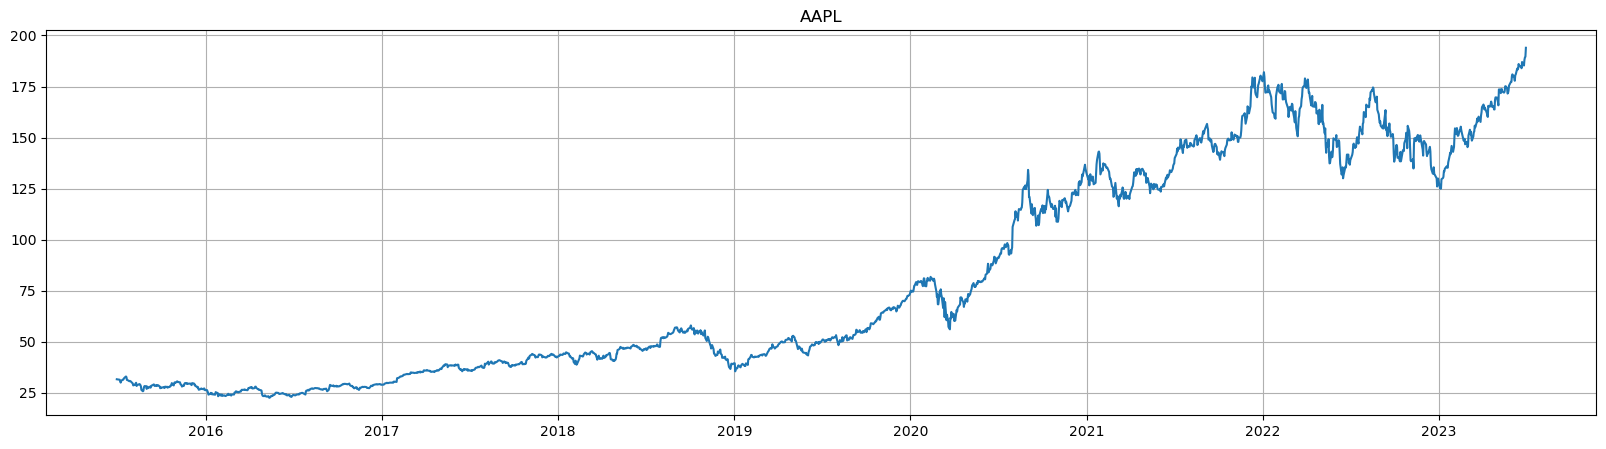

In [9]:
plt.figure(figsize=(20,5))
plt.plot(df.Close)
plt.title("AAPL")
plt.grid()

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing valueŝ
ser = df.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [11]:
int(series.shape[0]*0.9)

1812

In [12]:
closetrain,closetest,closeforecast=get_data(7,series)

In [13]:
window_size=31
predday=7
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [14]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [19]:
path=r'Model1_pred_7days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [20]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
56/56 [==============================] - 5s 66ms/step - loss: 1.1439e-04 - mse: 2.2877e-04 - val_loss: 2.6029e-04 - val_mse: 5.2058e-04
Epoch 2/10
56/56 [==============================] - 3s 59ms/step - loss: 1.1011e-04 - mse: 2.2022e-04 - val_loss: 3.1830e-04 - val_mse: 6.3659e-04
Epoch 3/10
56/56 [==============================] - 4s 62ms/step - loss: 1.1629e-04 - mse: 2.3258e-04 - val_loss: 8.8564e-04 - val_mse: 0.0018
Epoch 4/10
56/56 [==============================] - 3s 60ms/step - loss: 1.1378e-04 - mse: 2.2757e-04 - val_loss: 4.2502e-04 - val_mse: 8.5004e-04
Epoch 5/10
56/56 [==============================] - 3s 61ms/step - loss: 1.4028e-04 - mse: 2.8057e-04 - val_loss: 8.2417e-04 - val_mse: 0.0016
Epoch 6/10
56/56 [==============================] - 4s 64ms/step - loss: 1.1609e-04 - mse: 2.3217e-04 - val_loss: 3.6837e-04 - val_mse: 7.3674e-04
Epoch 7/10
56/56 [==============================] - 4s 65ms/step - loss: 1.2117e-04 - mse: 2.4234e-04 - val_loss: 3.5987e-04 -

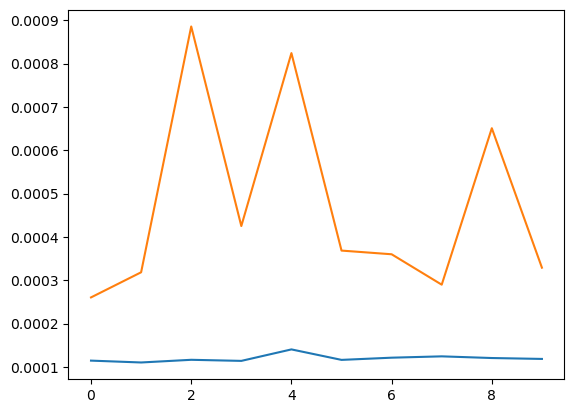

In [21]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [22]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

1/1 [==============================] - 0s 453ms/step


(8, 7)

In [23]:
testbatches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

1/1 [==============================] - 0s 19ms/step


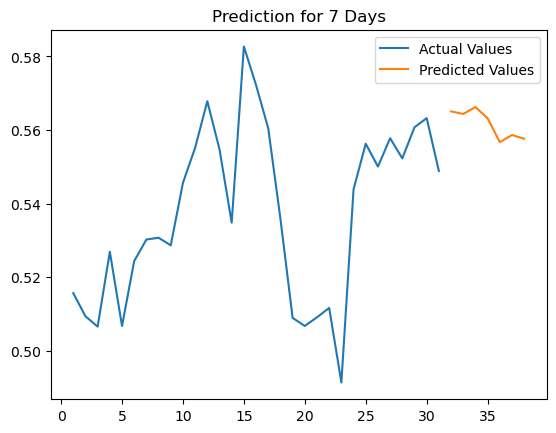

In [24]:
future_predicted(testbatches,window_size,predday)

1/1 [==============================] - 0s 61ms/step


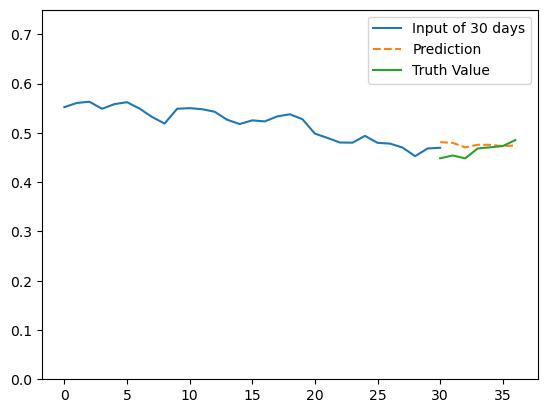

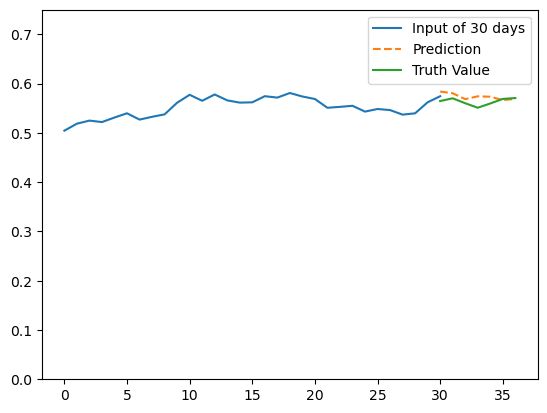

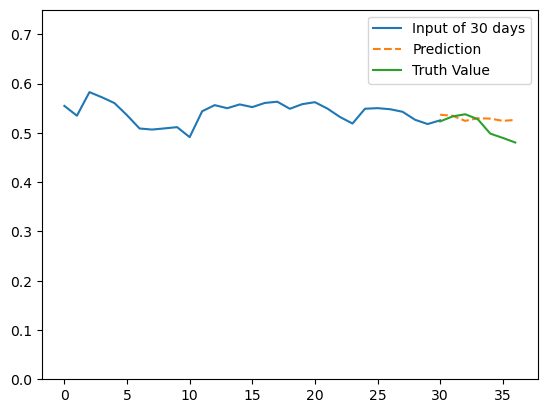

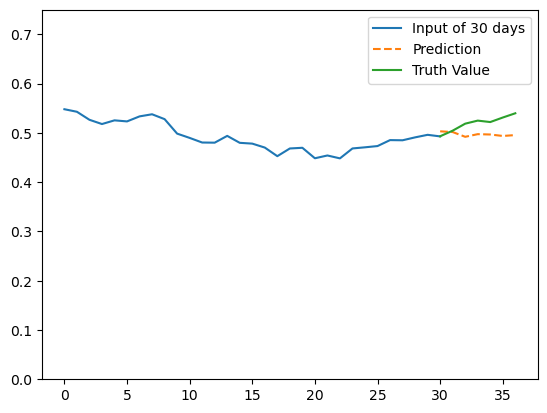

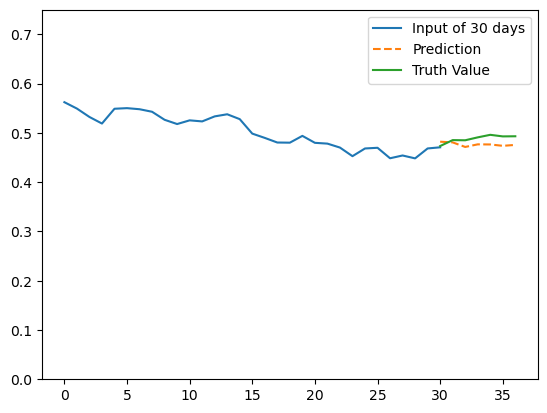

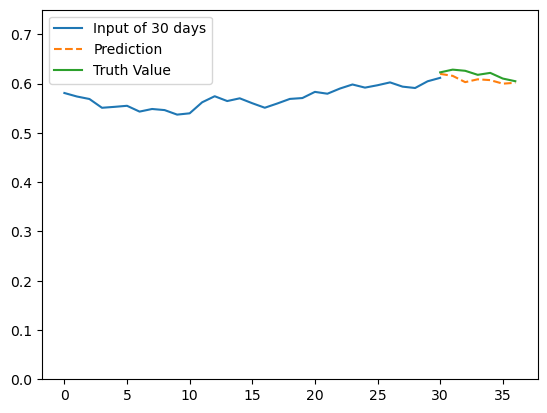

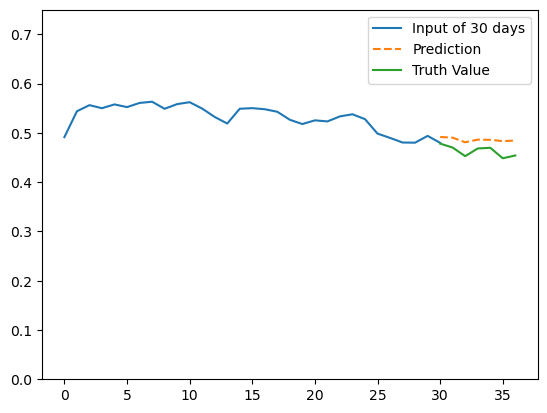

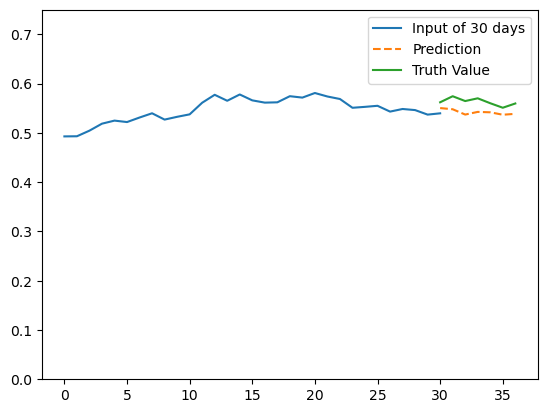

In [ ]:
visualplotloss(testbatches,model,window_size,predday)

In [25]:
model.evaluate(testbatches)

16/16 [==============================] - 0s 12ms/step - loss: 3.2893e-04 - mse: 6.5786e-04


[0.00032892878516577184, 0.0006578575703315437]

**Model 2**

In [26]:
path=r'Model2_pred_14days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 14)                9

In [27]:
closetrain,closetest,closeforecast=get_data(14,series)

In [28]:
window_size=62
predday=14
trainbatches =  windowed_dataset(closetrain,62,14)
testbatches =  windowed_dataset(closetest,62,14,batch_size=8)

In [29]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
55/55 [==============================] - 8s 117ms/step - loss: 2.8219e-04 - mse: 5.6439e-04 - val_loss: 4.9998e-04 - val_mse: 9.9997e-04
Epoch 2/10
55/55 [==============================] - 6s 112ms/step - loss: 2.3215e-04 - mse: 4.6429e-04 - val_loss: 7.2262e-04 - val_mse: 0.0014
Epoch 3/10
55/55 [==============================] - 6s 116ms/step - loss: 2.3661e-04 - mse: 4.7323e-04 - val_loss: 4.9149e-04 - val_mse: 9.8299e-04
Epoch 4/10
55/55 [==============================] - 7s 119ms/step - loss: 2.6031e-04 - mse: 5.2061e-04 - val_loss: 5.8701e-04 - val_mse: 0.0012
Epoch 5/10
55/55 [==============================] - 7s 120ms/step - loss: 2.3189e-04 - mse: 4.6379e-04 - val_loss: 5.9452e-04 - val_mse: 0.0012
Epoch 6/10
55/55 [==============================] - 7s 121ms/step - loss: 2.5975e-04 - mse: 5.1950e-04 - val_loss: 6.2146e-04 - val_mse: 0.0012
Epoch 7/10
55/55 [==============================] - 7s 119ms/step - loss: 3.1535e-04 - mse: 6.3070e-04 - val_loss: 4.6432e-04 - 

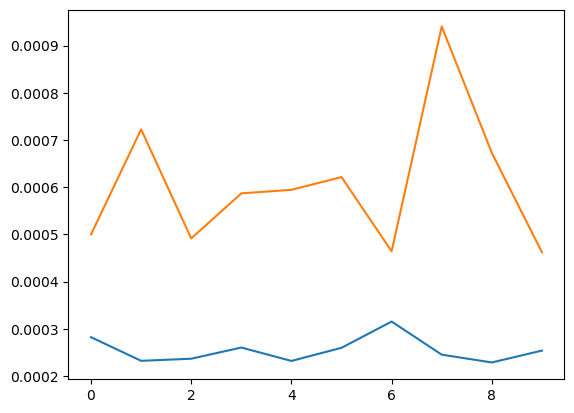

In [30]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [31]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

1/1 [==============================] - 0s 456ms/step


(8, 14)

1/1 [==============================] - 0s 26ms/step


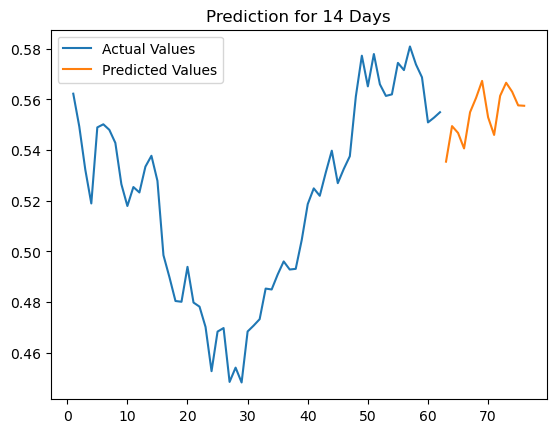

In [32]:
future_predicted(testbatches,window_size,predday)

1/1 [==============================] - 0s 32ms/step


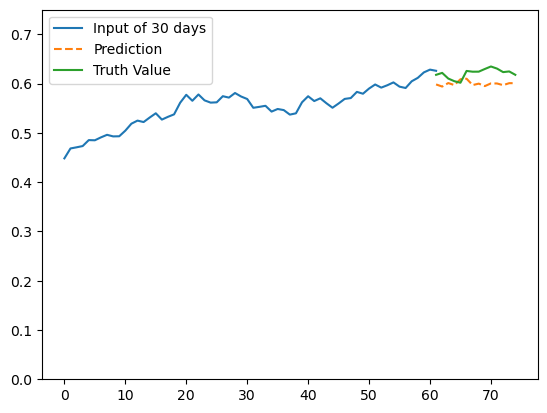

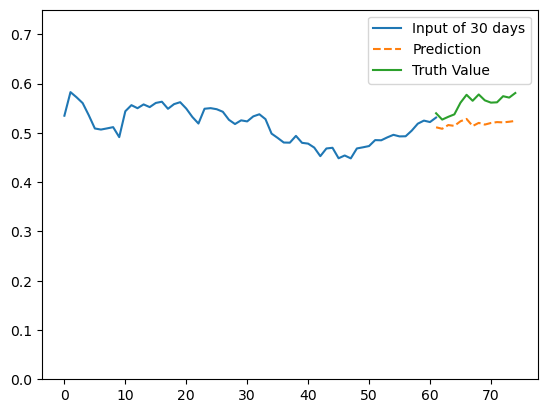

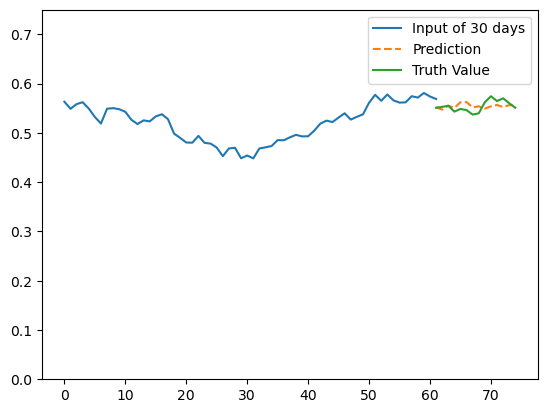

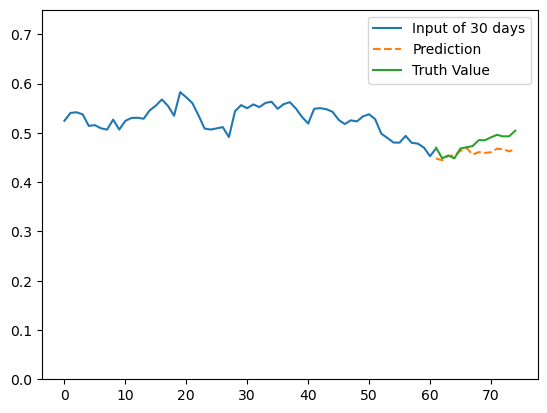

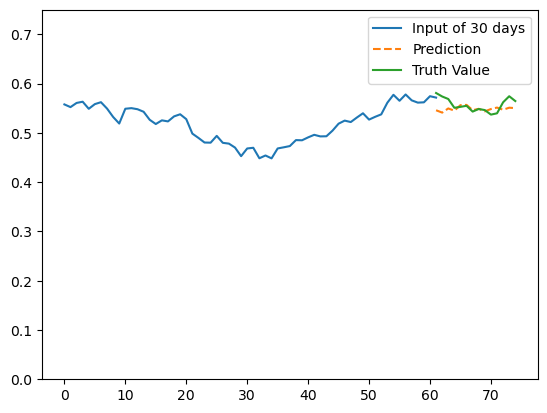

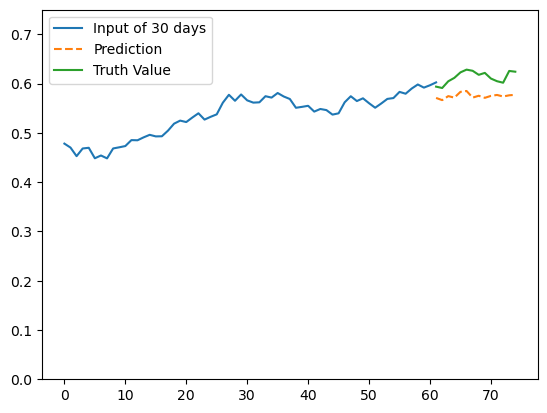

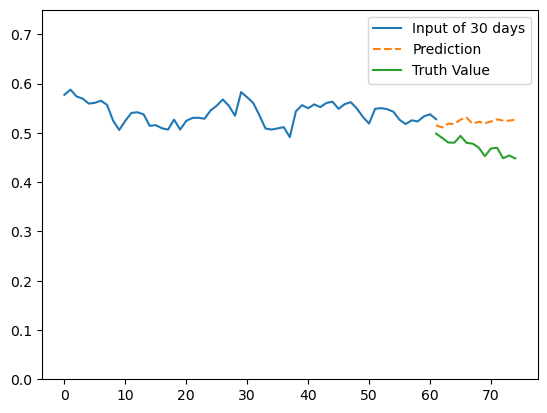

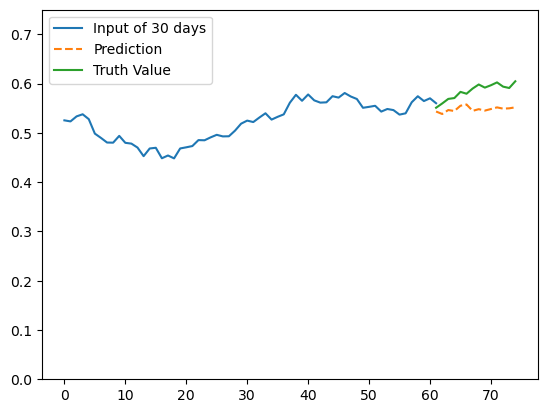

In [ ]:
visualplotloss(testbatches,model,window_size,predday)

**Model 3**

In [33]:
path=r'Model_3_Pred21_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1

In [34]:
closetrain,closetest,closeforecast=get_data(21,series)

In [35]:
window_size=90
predday=21
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [36]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10


54/54 [==============================] - 10s 159ms/step - loss: 6.5049e-04 - mse: 6.5049e-04 - val_loss: 9.1355e-04 - val_mse: 9.1355e-04
Epoch 2/10
54/54 [==============================] - 8s 153ms/step - loss: 7.2091e-04 - mse: 7.2091e-04 - val_loss: 9.4312e-04 - val_mse: 9.4312e-04
Epoch 3/10
54/54 [==============================] - 9s 162ms/step - loss: 8.2499e-04 - mse: 8.2499e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/10
54/54 [==============================] - 9s 166ms/step - loss: 7.4423e-04 - mse: 7.4423e-04 - val_loss: 7.1482e-04 - val_mse: 7.1482e-04
Epoch 5/10
54/54 [==============================] - 9s 164ms/step - loss: 6.6699e-04 - mse: 6.6699e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/10
54/54 [==============================] - 9s 161ms/step - loss: 7.6434e-04 - mse: 7.6434e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/10
54/54 [==============================] - 8s 156ms/step - loss: 6.8350e-04 - mse: 6.8350e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 

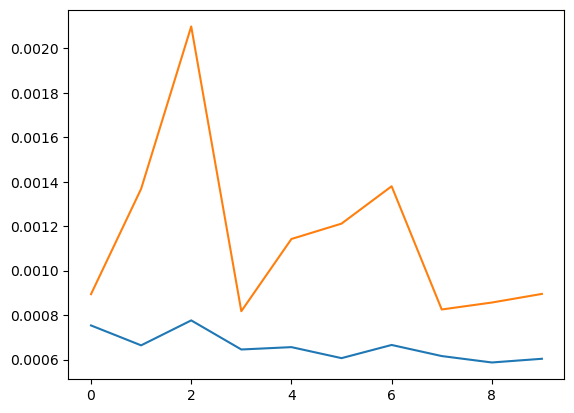

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

1/1 [==============================] - 1s 733ms/step


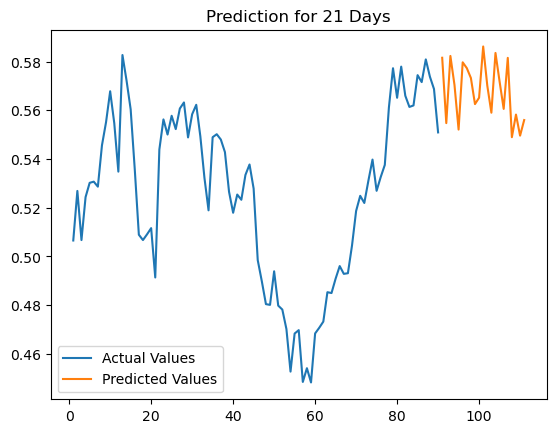

In [ ]:
future_predicted(testbatches,window_size,predday)

1/1 [==============================] - 0s 37ms/step


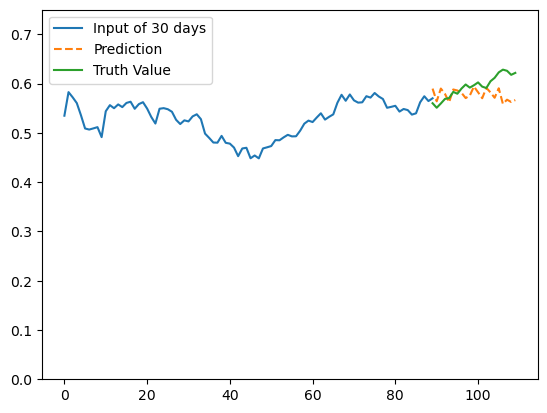

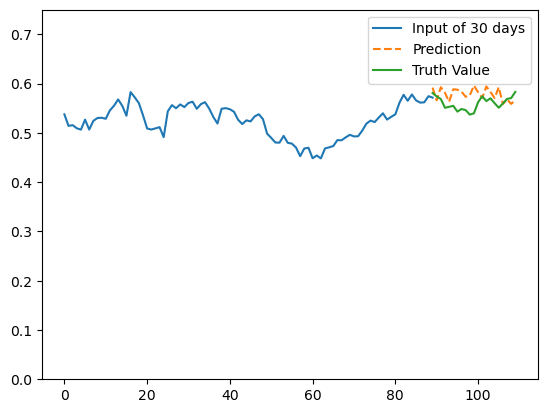

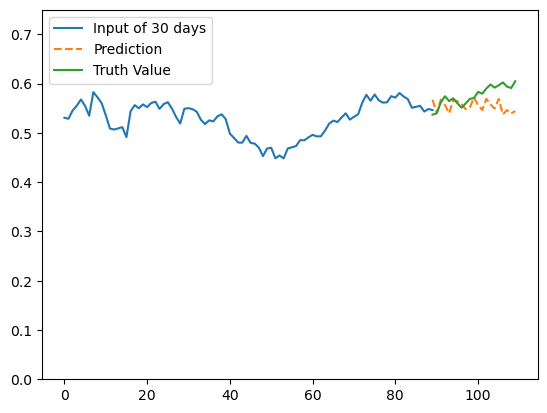

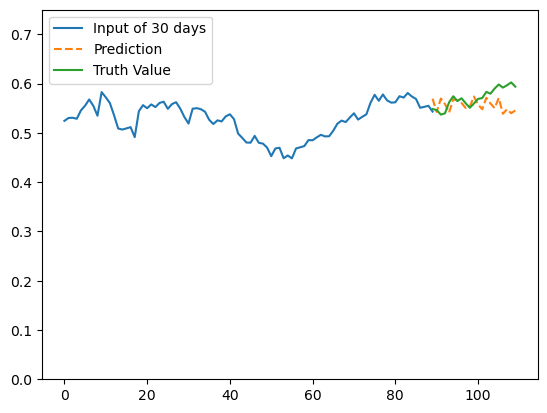

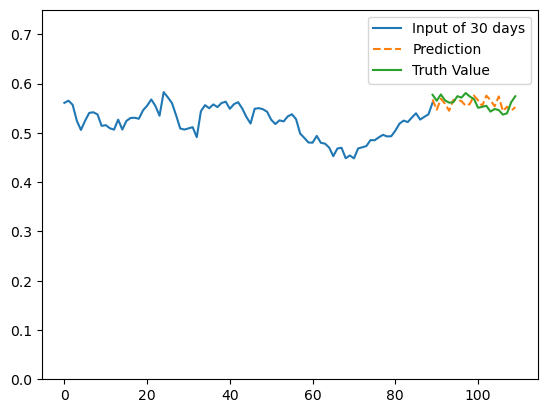

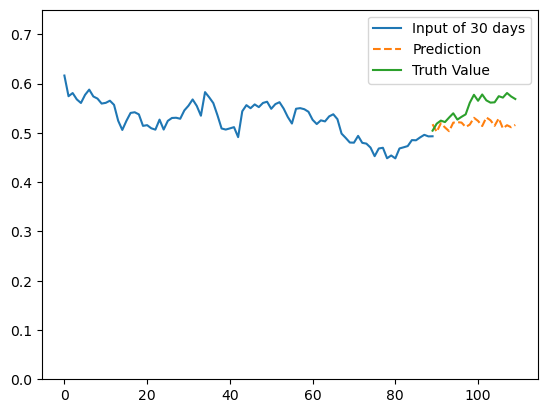

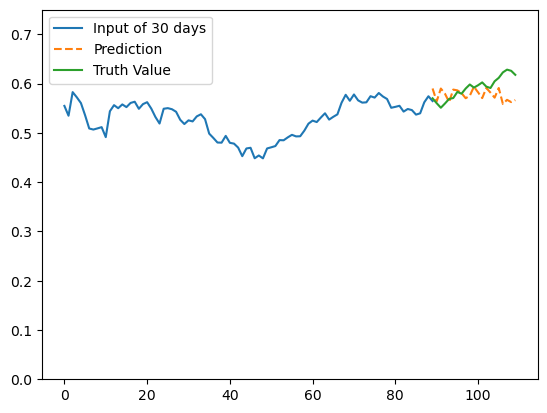

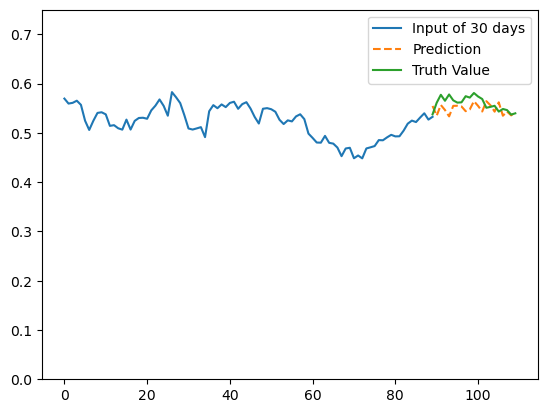

In [ ]:
visualplotloss(testbatches,model,window_size,predday)

**Model 4**

In [37]:
path=r'Model_4_Pred28_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 28)                1

In [ ]:
closetrain,closetest,closeforecast=get_data(28,series)

In [ ]:
window_size=128
predday=28
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [ ]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10


52/52 [==============================] - 37s 570ms/step - loss: 6.4973e-04 - mse: 0.0013
Epoch 2/10
52/52 [==============================] - 26s 488ms/step - loss: 4.7396e-04 - mse: 9.4791e-04
Epoch 3/10
52/52 [==============================] - 25s 483ms/step - loss: 4.9923e-04 - mse: 9.9847e-04
Epoch 4/10
52/52 [==============================] - 26s 489ms/step - loss: 4.9513e-04 - mse: 9.9027e-04
Epoch 5/10
52/52 [==============================] - 27s 506ms/step - loss: 5.0071e-04 - mse: 0.0010
Epoch 6/10
52/52 [==============================] - 26s 485ms/step - loss: 4.4868e-04 - mse: 8.9736e-04
Epoch 7/10
52/52 [==============================] - 25s 475ms/step - loss: 4.2355e-04 - mse: 8.4711e-04
Epoch 8/10
52/52 [==============================] - 27s 512ms/step - loss: 4.3848e-04 - mse: 8.7696e-04
Epoch 9/10
52/52 [==============================] - 26s 490ms/step - loss: 4.1715e-04 - mse: 8.3430e-04
Epoch 10/10
52/52 [==============================] - 25s 478ms/step - loss: 4.5088e

In [ ]:
hist

{'loss': [0.0005769825074821711,
  0.00045593181857839227,
  0.00045256310841068625,
  0.0004859018081333488,
  0.0005324864177964628,
  0.0004379393649287522,
  0.0004284178139641881,
  0.00043784547597169876,
  0.00043966228258796036,
  0.0005090165650472045],
 'mse': [0.0011539650149643421,
  0.0009118636371567845,
  0.0009051262168213725,
  0.0009718036162666976,
  0.0010649728355929255,
  0.0008758787298575044,
  0.0008568356279283762,
  0.0008756909519433975,
  0.0008793245651759207,
  0.001018033130094409]}

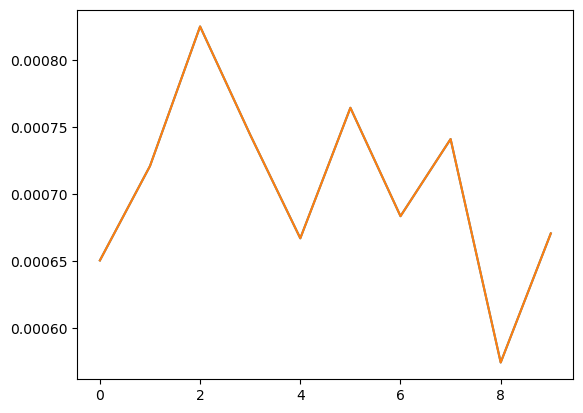

In [38]:
plt.plot(hist["loss"])
plt.plot(hist["mse"])
plt.show()

In [ ]:
future_predicted(testbatches,window_size,predday)

StopIteration: 

In [ ]:
visualplotloss(testbatches,model,window_size,predday)

StopIteration: 

**Model 5**

In [39]:
path=r'Model5_Pred_35Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         768       
                                                                 
 lstm (LSTM)                 (None, None, 128)         131584    
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 35)                2

In [40]:
closetrain,closetest,closeforecast=get_data(35,series)

In [41]:
window_size=150
predday=35
trainbatches =  windowed_dataset(closetrain,150,35)
testbatches =  windowed_dataset(closetest,150,35,batch_size=8)

In [42]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
51/51 [==============================] - 15s 274ms/step - loss: 5.7943e-04 - mse: 0.0012
Epoch 2/10
51/51 [==============================] - 14s 274ms/step - loss: 5.2959e-04 - mse: 0.0011
Epoch 3/10
51/51 [==============================] - 14s 277ms/step - loss: 5.1966e-04 - mse: 0.0010
Epoch 4/10
51/51 [==============================] - 15s 291ms/step - loss: 5.6637e-04 - mse: 0.0011
Epoch 5/10
51/51 [==============================] - 16s 310ms/step - loss: 4.9175e-04 - mse: 9.8350e-04
Epoch 6/10
51/51 [==============================] - 15s 286ms/step - loss: 5.8269e-04 - mse: 0.0012
Epoch 7/10


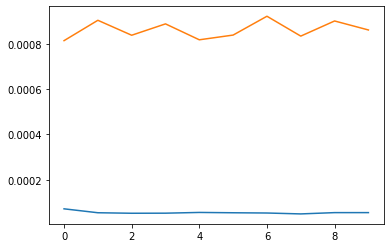

In [ ]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

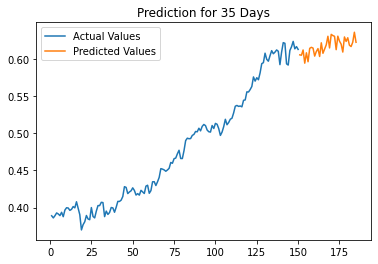

In [ ]:
future_predicted(testbatches,window_size,predday)

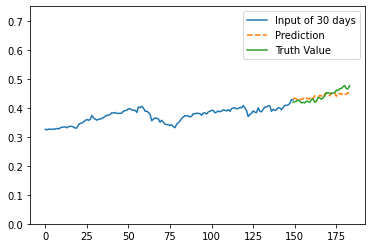

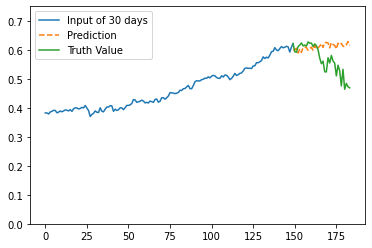

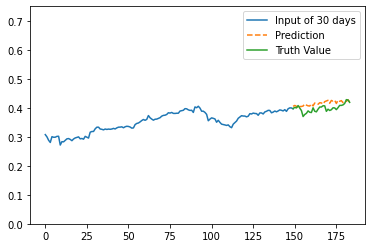

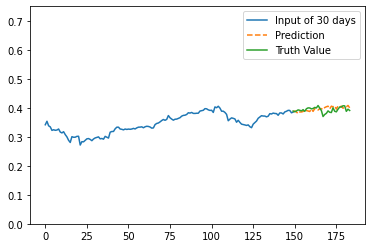

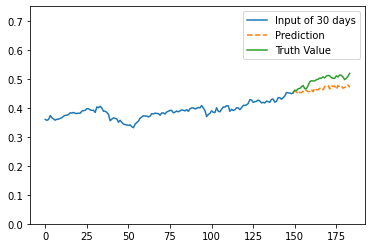

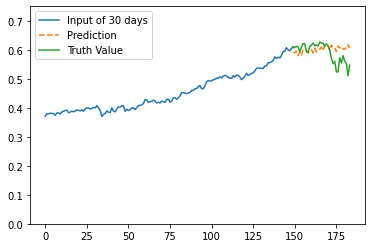

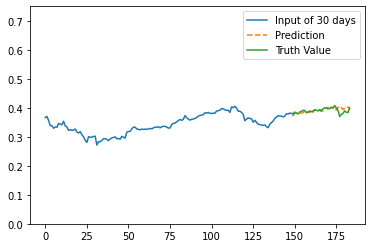

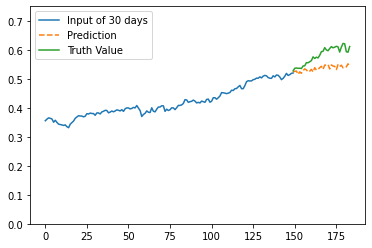

In [ ]:
visualplotloss(testbatches,model,window_size,predday)